# Mask R-CNN with OpenCV for Object Detection
The objective of this project is to detect and also segment images, based on pre-trained Tensorflow based object detection models.

Detection is identifying a bounding box, instance segmentation requires identifying the pixels that can belong to the object.

Will use R-Mask CNN model with inception 2. R-CNN  does detection in multiple stage with multiple CNN passes. At first it generates proposal regions by studying pixel gradients and edges. Classification is run on each proposal. The final results and bounding boxes are then obtained post-processing of the individual results.
 


# Importing the Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
np.random.seed(42)

In [2]:
def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Getting the class names

In [3]:
label_file = "/kavyapan/mask_rcnn_model_data/object_detection_classes_coco.txt"
LABELS = open(label_file).read().strip().split("\n")

In [4]:
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

In [5]:
LABELS[:5]

['person', 'bicycle', 'car', 'motorcycle', 'airplane']

# Getting the Model, Weights and Configs of the Network

In [6]:
#Setting weights to the path of the model weights file
weights = "/kavyapan/mask_rcnn_model_data/mask_rcnn_frozen_inference_graph.pb"

#Setting config to the path of the model configurations file
config = "/kavyapan/mask_rcnn_model_data/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"

#Reading the network model stored in TensorFlow framework’s format
net = cv2.dnn.readNetFromTensorflow(weights, config)

# Reading and Preprocessing the image

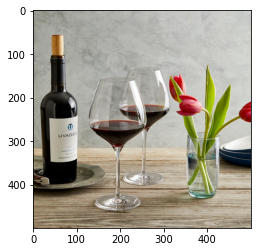

In [7]:
#Reading the image file and converting it to a blob
img = cv2.imread('/kavyapan/mask_rcnn_model_data/dining_table.jpg')
plt.imshow(fixColor(img))
blob = cv2.dnn.blobFromImage(img, swapRB=True, crop=False)
net.setInput(blob)

# Getting the Masks and Bounding Boxes

In [8]:
(boxes, masks_polygons) = net.forward(["detection_out_final",
"detection_masks"])
boxes.shape

(1, 1, 7, 7)

###### The boxes have classID, confidence scores and 4 points identifying the bounding box. This bounding box is normalized and has to be multiplied by the actual size of the image to get actual values.

In [9]:
masks_polygons.shape

(100, 90, 15, 15)

###### The masks_polygons have

Masks corresponding to the 100 detections

Each detection has 90 classes. (would be considering the classID whose confidence is greater than threshold).

A matrix denoted as a 15 x 15 mask polygon of the detected object

# Filtering and Visualizing the Detections

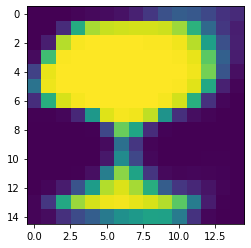

Shape of individual mask (15, 15)
Mask after resize (328, 148)
Mask after threshold (328, 148)
ROI Shape (12764, 3)
wine glass [156, 21, 112]


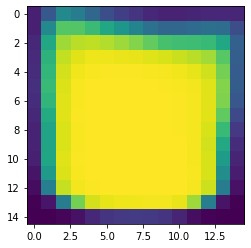

Shape of individual mask (15, 15)
Mask after resize (154, 81)
Mask after threshold (154, 81)
ROI Shape (6072, 3)
vase [166, 56, 167]


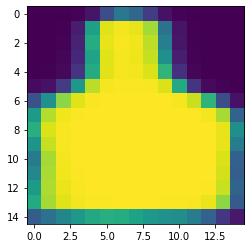

Shape of individual mask (15, 15)
Mask after resize (344, 83)
Mask after threshold (344, 83)
ROI Shape (13497, 3)
bottle [209, 226, 77]


In [10]:
threshold = 0.9
for i in range(0, boxes.shape[2]): #For each detection
    classID = int(boxes[0, 0, i, 1]) #Class ID
    confidence = boxes[0, 0, i, 2] #Confidence scores
    if confidence > threshold:
        (H, W) = img.shape[:2]
        box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H]) #Bounding box
        (startX, startY, endX, endY) = box.astype("int")
        boxW = endX - startX
        boxH = endY - startY

        # extract the pixel-wise segmentation for the object, and visualize the mask       
        mask = masks_polygons[i, classID]
        plt.imshow(mask)
        plt.show()
        print ("Shape of individual mask", mask.shape)

        # resize the mask such that it's the same dimensions of
        # the bounding box, and interpolation gives individual pixel positions
        mask = cv2.resize(mask, (boxW, boxH), interpolation=cv2.INTER_CUBIC)

        print ("Mask after resize", mask.shape)
        # then finally threshold to create a *binary* mask
        mask = (mask > threshold)
        print ("Mask after threshold", mask.shape)
        # extract the ROI of the image but *only* extracted the
        # masked region of the ROI
        roi = img[startY:endY, startX:endX][mask]
        print ("ROI Shape", roi.shape)

        # grab the color used to visualize this particular class,
        # then create a transparent overlay by blending the color
        # with the ROI
        color = COLORS[classID]
        blended = ((0.4 * color) + (0.6 * roi)).astype("uint8")

        # Change the colors in the original to blended color
        img[startY:endY, startX:endX][mask] = blended

        color = COLORS[classID]
        color = [int(c) for c in color]
        print (LABELS[classID], color)
        cv2.rectangle(img, (startX, startY), (endX, endY), color, 2)
        text = "{}: {:.4f}".format(LABELS[classID], confidence)
        cv2.putText(img, text, (startX, startY - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

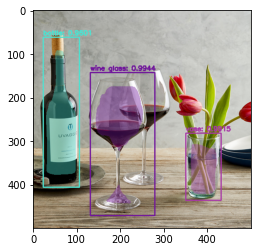

In [11]:
plt.imshow(fixColor(img))